### Geomagnetic Induction in Submarine Cable during the March 1989 Geomagnetic Storm
---
* __author__ = [Chakraborty, S.; Boteler, D. B. H.]
* __copyright__ = 
* __credits__ = []
* __license__ = MIT
* __version__ = 1.0
* __maintainer__ = Chakraborty, S.
* __email__ = shibaji7@vt.edu
* __status__ = Research

>  

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.fftpack
from scipy.stats import pearsonr

import bezpy
from gic.model.oml import OceanModel
from gic.model.utils import RecursiveNamespace
from gic.validation.simulate_synB_synT import CableAnalysis

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(["science", "ieee"])
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

%matplotlib inline

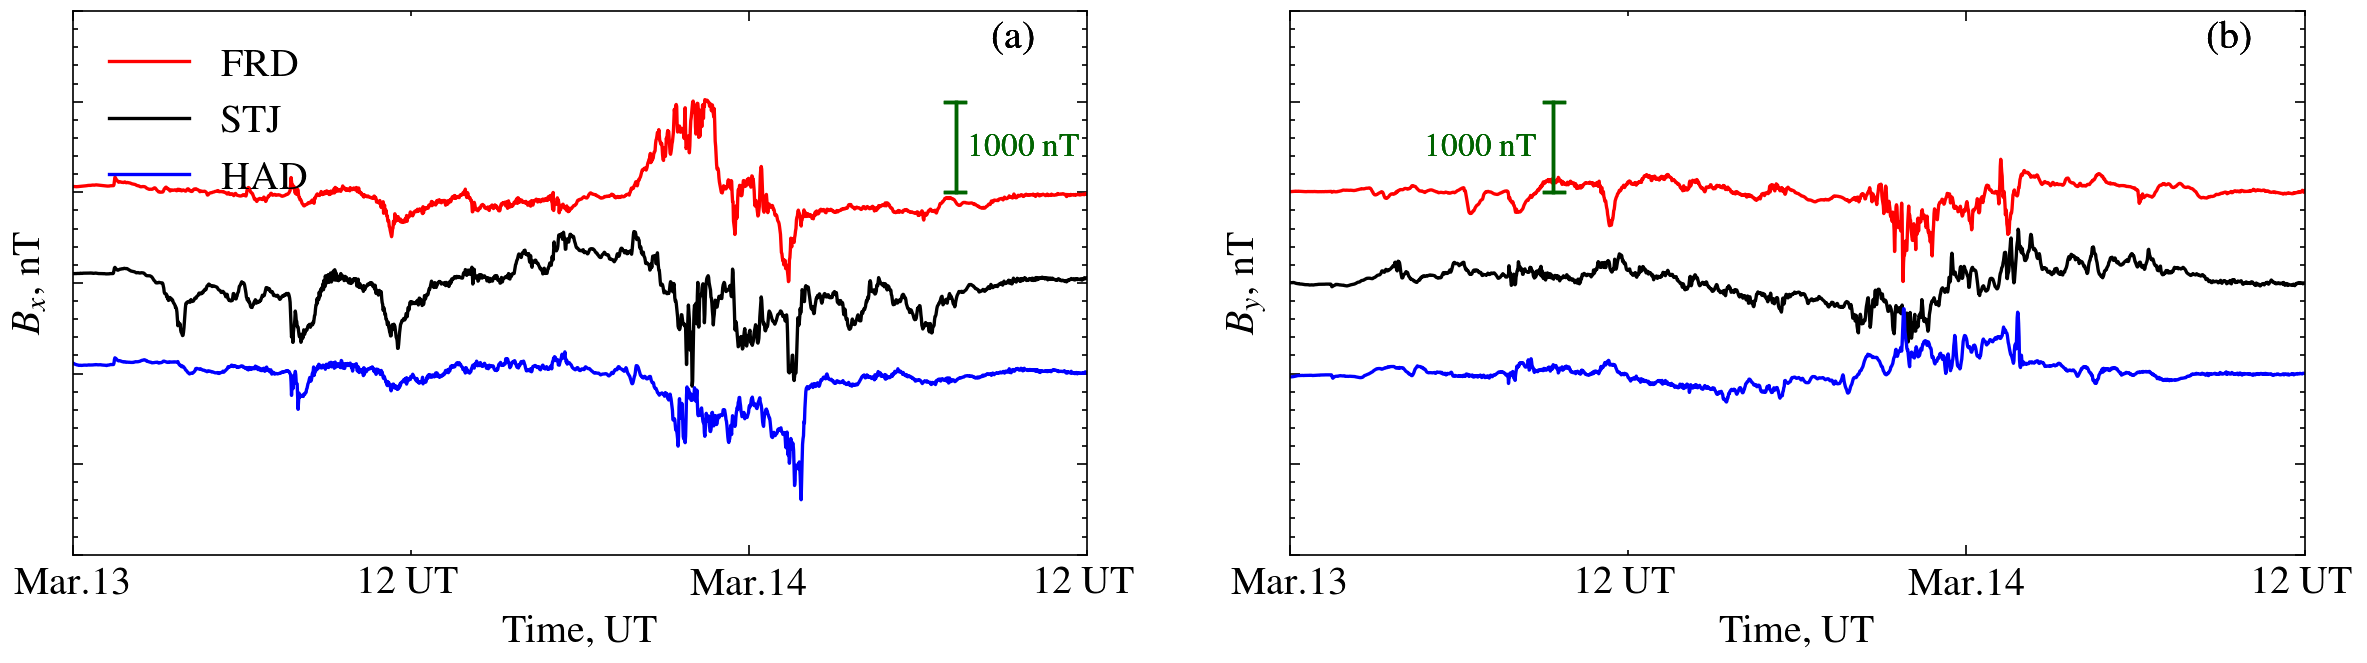

In [2]:
stns, coords = ["FRD", "STJ", "HAD"], ["XYZ", "XYZ", "HDZ"]
db="input/data/{year}/"
dates, frames = [dt.datetime(1989,3,12),dt.datetime(1989,3,13),dt.datetime(1989,3,14)], {}
for stn, coord in zip(stns, coords):
    o = pd.DataFrame()
    for d in dates:
        f = db.format(year=d.year) + "{stn}_{date}_{coord}.txt".format(stn=stn, 
                                                                       date=d.strftime("%Y%m%d"), 
                                                                       coord=coord)
        o = pd.concat([o, bezpy.mag.read_iaga(f)])
    frames[stn] = o

mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=240, figsize=(12, len(stns)))
multiplier, colors = [1, 0, -1], ["r", "k", "b"]
base=1000
for i, stn in enumerate(stns):
    frame = frames[stn]
    ax = axes[0]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    ax.plot(frame.index, (base*multiplier[i])+frame.X-np.mean(frame.X), colors[i], ls="-", lw=1., label=stn.upper())
    ax.set_ylabel(r"$B_x$, nT", fontdict={"color": "k"})
    ax.set_ylim(-3000,3000)
    ax.axvline(frame.index.tolist()[-1000], ymin=4/6, ymax=5/6, color = "darkgreen", drawstyle="steps-mid")
    ax.axhline(2000, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.axhline(1000, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.text(frame.index.tolist()[-970], 1500, "1000 nT", ha="left", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_yticklabels([])
    ax.legend(loc=2)
    ax.text(0.95,0.95,"(a)",ha="right",va="center",transform=ax.transAxes)
    ax = axes[1]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    ax.plot(frame.index, (base*multiplier[i])+frame.Y-np.mean(frame.Y), colors[i], ls="-", lw=1., label=stn.upper())
    ax.set_ylabel(r"$B_y$, nT", fontdict={"color": "k"})
    ax.axvline(frame.index.tolist()[2000], ymin=4/6, ymax=5/6, color = "darkgreen", drawstyle="steps-mid")
    ax.axhline(2000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
    ax.axhline(1000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
    ax.text(frame.index.tolist()[1970], 1500, "1000 nT", ha="right", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_ylim(-3000,3000)
    ax.set_yticklabels([])
    ax.text(0.95,0.95,"(b)",ha="right",va="center",transform=ax.transAxes)
axes[0].set_xlabel("Time, UT")
axes[1].set_xlabel("Time, UT")
fig.subplots_adjust(wspace=.2, hspace=.1)
fig.savefig("tmp/Bxy.Field.png", bbox_inches="tight")

In [3]:
# Generate Ocean-Earth Models for 9 segments
segment_name = ["CS-W", "DO-1", "DO-2", "DO-3", "DO-4", "DO-5", "MAR", "DO-6", "CS-E"]
# Ocean resitivity
ocean_resistivity = 0.3
# Resistivities of the earth layers
earth_resistivities = np.array([3, 3000, 1000, 100, 10, 1])
# Thicknesses of the Ocan [index 0] the Earth layers
ocean_thicknesses = np.array([0.1, 4, 5.2, 4, 4.8, 4, 3, 4.5, 0.1])*1e3
# Thikness of the different earth layers at 9 segments
segments = {
    "CS-W": np.array([8, 15, 150, 236.9, 250, 340])*1e3,
    "DO-1": np.array([4, 10, 145, 247, 250, 340])*1e3,
    "DO-2": np.array([2, 10, 140, 252.8, 250, 340])*1e3,
    "DO-3": np.array([2, 10, 140, 254, 250, 340])*1e3,
    "DO-4": np.array([1, 10, 70, 324.2, 250, 340])*1e3,
    "DO-5": np.array([0.5, 10, 60, 335.5, 250, 340])*1e3,
    "MAR": np.array([0, 10, 25, 372, 250, 340])*1e3,
    "DO-6": np.array([1.5, 10, 70, 324, 250, 340])*1e3,
    "CS-E": np.array([3, 20, 120, 266.9, 250, 340])*1e3,
}
# Frequency limits
flim = [1e-6, 1e-2]
# List of all transfer functions
TxList = []
for i, s_name in enumerate(segment_name):
    ocean_model = {
        "depth": ocean_thicknesses[i], 
        "rho": ocean_resistivity,
    }
    # Create ocean-earth leayerd model
    om = OceanModel(
        segments[s_name], 
        earth_resistivities, 
        ocean_model=ocean_model, 
        flim=flim
    )
    # Get transfer function
    Tx = om.get_TFs()
    TxList.append(Tx)

# Plot transfer function (amplitude and phase)
labs = ["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)","(i)"]
fig = plt.figure(dpi=240, figsize=(8,8))
for i in range(9):
    ax = fig.add_subplot(331+i)
    ax.loglog(TxList[i].freq, np.abs(TxList[i].E2B), "r", lw=0.6, ls="-")
    if i in [6,7,8]: ax.set_xlabel(r"$f_0$, in Hz")
    else: ax.set_xticks([])
    if i in [0,3,6]: ax.set_ylabel(r"$|T_x|$, in mV/km/nT", color="r")
    else: ax.set_yticks([])
    ax.set_xlim(1e-6,1e-2)
    ax.set_ylim(1e-3,1e0)
    ax.text(0.9, 0.9, segment_name[i], ha="right", va="center", transform=ax.transAxes)
    ax = ax.twinx()
    ax.semilogx(TxList[i].freq, np.angle(TxList[i].E2B, deg=True), "b", lw=0.6, ls="-")
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    if i in [2,5,8]: ax.set_ylabel(r"$\arctan(T_x)$, in $(^\circ)$", color="b")
    else: ax.set_yticks([])
    if i not in [6,7,8]: ax.set_xticks([])
    ax.set_ylim(-90, 90)
    _ = ax.set_xlim(1e-6,1e-2)
    ax.text(0.95,0.1,labs[i],ha="right",va="center",transform=ax.transAxes)
fig.subplots_adjust(wspace=0.2,hspace=0.2)

2022-09-28 20:34:48.775 | INFO     | gic.model.oml:__init__:63 - Compile OM[] to calc O(floor) E- and B-Fields


TypeError: calcZ() got an unexpected keyword argument 'lev'

In [ ]:
# Input Control JSON for Ocean-Earth model
ICJ = {
    "sid": 5,
    "opcode": 0,
    "Bfield": {
        "data_sources": { # Source of the datasets
            "stns": ["FRD", "HAD", "STJ"],
            "sources": [ # Linking data files to stations
                "input/data/1989/FRD_19890312_XYZ.txt",
                "input/data/1989/FRD_19890313_XYZ.txt",
                "input/data/1989/FRD_19890314_XYZ.txt",
                "input/data/1989/HAD_19890312_HDZ.txt",
                "input/data/1989/HAD_19890313_HDZ.txt",
                "input/data/1989/HAD_19890314_HDZ.txt",
                "input/data/1989/STJ_19890312_XYZ.txt",
                "input/data/1989/STJ_19890313_XYZ.txt",
                "input/data/1989/STJ_19890314_XYZ.txt",
            ],
        },
        "tapering": 0.1 # Tapering coefficient
    },
    "cable": { # Cable description
        "cable_sections": [ # Description of cable sections
            {
                "sec_id": 1,
                "station": "FRD",
                "elec_params": {
                    "earth_model": "CS-W", # CS-W Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 100, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 39.6, "lon": -74.33
                    },
                    "fin": { # Final lat/lon
                        "lat": 38.79, "lon": -72.62
                    }
                },
            },
            {
                "sec_id": 2,
                "station": "FRD",
                "elec_params": {
                    "earth_model": "DO-1", # DO-1 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4000, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 38.79, "lon": -72.62
                    },
                    "fin": { # Final lat/lon
                        "lat": 37.11, "lon": -68.94
                    }
                },
            },
            {
                "sec_id": 3,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "DO-2", # DO-2 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 5200, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 37.11, "lon": -68.94
                    },
                    "fin": { # Final lat/lon
                        "lat": 39.80, "lon": -48.20
                    }
                },
            },
            {
                "sec_id": 4,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "DO-3", # DO-3 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4000, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 39.80, "lon": -48.20
                    },
                    "fin": { # Final lat/lon
                        "lat": 40.81, "lon": -45.19
                    }
                },
            },
            {
                "sec_id": 5,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "DO-4", # DO-4 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4800, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 40.81, "lon": -45.19
                    },
                    "fin": { # Final lat/lon
                        "lat": 43.15, "lon": -39.16
                    }
                },
            },
            {
                "sec_id": 6,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "DO-5", # DO-5 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4000, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 43.15, "lon": -39.16
                    },
                    "fin": { # Final lat/lon
                        "lat": 44.83, "lon": -34.48
                    }
                },
            },
            {
                "sec_id": 7,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "MAR", # MAR Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 3000, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 44.83, "lon": -34.48
                    },
                    "fin": { # Final lat/lon
                        "lat": 46.51, "lon": -22.43
                    }
                },
            },
            {
                "sec_id": 8,
                "station": "HAD",
                "elec_params": {
                    "earth_model": "DO-6", # DO-6 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4500, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 46.51, "lon": -22.43
                    },
                    "fin": { # Final lat/lon
                        "lat": 47.85, "lon": -9.05
                    }
                },
            },
            {
                "sec_id": 9,
                "station": "HAD",
                "elec_params": {
                    "earth_model": "CS-E", # CS-E Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 100, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 47.85, "lon": -9.05
                    },
                    "fin": { # Final lat/lon
                        "lat": 50.79, "lon": -4.55
                    }
                },
            }
        ],
        "cable_pot_plot_index": 0
    },
    "out_dir": "tmp/out/005/", # Output directory
    "opname": "March 1989 Storm Analysis"
}

control = RecursiveNamespace(**ICJ)
cable = CableAnalysis(control.Bfield, control.cable, control.out_dir)
cable.run()
params = cable.cbl.tot_params

In [ ]:
mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=240, figsize=(10, 4))
multiplier, colors = [4,3,2,1,0,-1,-2,-3,-4], ["r", "k", "b"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", 
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
base=100
for i in range(9):
    ax = axes[0]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    ax.plot(
        params.index, 
        (base*multiplier[i])+params["E.X.%02d"%(i)]-np.mean(params["E.X.%02d"%(i)]), 
        colors[i], 
        ls="-", 
        lw=0.6
    )
    ax.set_ylabel(r"$E_x$, in mV/km", fontdict={"color": "k"})
    ax.set_ylim(-700,700)
    ax.text(0.05,0.95,"(a)",ha="left",va="center",transform=ax.transAxes)
    if i==0:
        ax.axvline(params.index.tolist()[-1100], ymin=11/14, ymax=13/14, 
                   color = "darkgreen", drawstyle="steps-mid")
        ax.axhline(400, xmin=0.815, xmax=0.815+2e-2, color = "darkgreen")
        ax.axhline(600, xmin=0.815, xmax=0.815+2e-2, color = "darkgreen")
        ax.text(params.index.tolist()[-1070], 500, "200 mV/km", ha="left", va="center", 
                fontdict={"color": "darkgreen", "size":10})
    ax.set_yticklabels([])
    ax.legend(loc=2)
    ax = axes[1]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    txt = r"%s[%s]"%(segment_name[i], control.cable.cable_sections[i].station)
    ax.plot(
        params.index, 
        (base*multiplier[i])+params["E.Y.%02d"%(i)]-np.mean(params["E.Y.%02d"%(i)]), 
        colors[i], 
        ls="-", 
        lw=0.6, 
        label=txt
    )
    ax.set_ylabel(r"$E_y$, in mV/km", fontdict={"color": "k"})
    if i==0:
        ax.axvline(params.index.tolist()[2000], ymin=11/14, ymax=13/14, 
                   color = "darkgreen", drawstyle="steps-mid")
        ax.axhline(400, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
        ax.axhline(600, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
        ax.text(params.index.tolist()[1970], 500, "200 mV/km", ha="right", va="center", 
                fontdict={"color": "darkgreen", "size":10})
        #ax.axvline(frame.index.tolist()[2000], ymin=4/6, ymax=5/6, color = "darkgreen", drawstyle="steps-mid")
        #ax.axhline(2000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
        #ax.axhline(1000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
        #ax.text(frame.index.tolist()[1970], 1500, "1000 nT", ha="right", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_ylim(-700,700)
    ax.set_yticklabels([])
    ax.text(0.05,0.95,"(b)",ha="left",va="center",transform=ax.transAxes)
axes[0].set_xlabel("Time, UT")
axes[1].set_xlabel("Time, UT")
axes[1].legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=10)
fig.subplots_adjust(wspace=.2, hspace=.2)
fig.savefig("tmp/Exy.Field.png", bbox_inches="tight")


In [ ]:
mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=240, figsize=(6, 4))
ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax.set_ylabel(r"$\mathcal{E}_{i}$, V", fontdict={"color": "k"})
base = 30
ax.set_ylim(-300, 200)
for i in range(9):
    ax.plot(
        params.index, 
        (base*multiplier[i])+params["V(v).%02d"%(i)]-np.mean(params["V(v).%02d"%(i)]), 
        colors[i], 
        ls="-", 
        lw=0.6,
        label=segment_name[i],
    )
    ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=10)
ax.axvline(params.index.tolist()[2000], ymin=40/50, ymax=45/50, 
                   color = "k", drawstyle="steps-mid")
ax.axhline(100, xmin=0.25, xmax=0.25+2e-2, color = "k")
ax.axhline(150, xmin=0.25, xmax=0.25+2e-2, color = "k")
ax.text(params.index.tolist()[1970], 125, "50 V", ha="right", va="center", 
        fontdict={"color": "k", "size":10})

In [ ]:
mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, axes = plt.subplots(nrows=4, ncols=1, dpi=240, figsize=(5, 12), sharex=True)
labs = ["(a)","(b)","(c)","(d)"]
for i, ax in enumerate(axes.ravel()):
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    if i==1:
        ax.set_ylabel(r"$U_W$, in Volts", fontdict={"color": "k"})
        ax.plot(params.index, params["U0"], "r", ls="-", lw=0.9, zorder=1)
        #ax.set_xlabel
    if i==2:
        ax.set_ylabel(r"$U_E$, in Volts", fontdict={"color": "k"})
        ax.plot(params.index, params["U1"], "b", ls="-", lw=0.9, zorder=1)
    if i==0:
        ax.set_ylabel(r"$\mathcal{E}$, in Volts", fontdict={"color": "k"})
        ax.plot(params.index, params["V(v)"], "darkgreen", ls="-", lw=0.9, zorder=1)
    if i==3:
        ax.set_ylabel(r"$V_{TAT-8}$, in Volts", fontdict={"color": "k"})
        ax.plot(params.index, params["Vt(v)"], "k", ls="-", lw=0.9, zorder=1)
    ax.set_ylim(-800, 800)
    ax.text(0.95,0.1,labs[i],ha="right",va="center",transform=ax.transAxes)
#ax.legend(loc="upper left", fontsize=10)
fig.autofmt_xdate()

In [ ]:
# Modified runs: (i) all segments with STJ station comprising Ey component only
# Input Control JSON for Ocean-Earth model
# ICJ = {
#     "sid": 5,
#     "opcode": 0,
#     "Bfield": {
#         "data_sources": { # Source of the datasets
#             "stns": ["FRD", "HAD", "STJ"],
#             "sources": [ # Linking data files to stations
#                 "input/data/1989/FRD_19890312_XYZ.txt",
#                 "input/data/1989/FRD_19890313_XYZ.txt",
#                 "input/data/1989/FRD_19890314_XYZ.txt",
#                 "input/data/1989/HAD_19890312_HDZ.txt",
#                 "input/data/1989/HAD_19890313_HDZ.txt",
#                 "input/data/1989/HAD_19890314_HDZ.txt",
#                 "input/data/1989/STJ_19890312_XYZ.txt",
#                 "input/data/1989/STJ_19890313_XYZ.txt",
#                 "input/data/1989/STJ_19890314_XYZ.txt",
#             ],
#         },
#         "tapering": 0.1 # Tapering coefficient
#     },
#     "cable": { # Cable description
#         "cable_sections": [ # Description of cable sections
#             {
#                 "sec_id": 1,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "CS-W", # CS-W Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 100, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 39.6, "lon": -74.33
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 38.79, "lon": -72.62
#                     }
#                 },
#             },
#             {
#                 "sec_id": 2,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-1", # DO-1 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4000, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 38.79, "lon": -72.62
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 37.11, "lon": -68.94
#                     }
#                 },
#             },
#             {
#                 "sec_id": 3,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-2", # DO-2 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 5200, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 37.11, "lon": -68.94
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 39.80, "lon": -48.20
#                     }
#                 },
#             },
#             {
#                 "sec_id": 4,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-3", # DO-3 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4000, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 39.80, "lon": -48.20
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 40.81, "lon": -45.19
#                     }
#                 },
#             },
#             {
#                 "sec_id": 5,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-4", # DO-4 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4800, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 40.81, "lon": -45.19
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 43.15, "lon": -39.16
#                     }
#                 },
#             },
#             {
#                 "sec_id": 6,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-5", # DO-5 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4000, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 43.15, "lon": -39.16
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 44.83, "lon": -34.48
#                     }
#                 },
#             },
#             {
#                 "sec_id": 7,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "MAR", # MAR Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 3000, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 44.83, "lon": -34.48
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 46.51, "lon": -22.43
#                     }
#                 },
#             },
#             {
#                 "sec_id": 8,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-6", # DO-6 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4500, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 46.51, "lon": -22.43
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 47.85, "lon": -9.05
#                     }
#                 },
#             },
#             {
#                 "sec_id": 9,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "CS-E", # CS-E Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 100, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 47.85, "lon": -9.05
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 50.79, "lon": -4.55
#                     }
#                 },
#             }
#         ],
#         "cable_pot_plot_index": 0
#     },
#     "out_dir": "tmp/out/005/", # Output directory
#     "opname": "March 1989 Storm Analysis"
# }

# control = RecursiveNamespace(**ICJ)
# cable = CableAnalysis(control.Bfield, control.cable, control.out_dir, ["X"])
# cable.run()
# params = cable.cbl.tot_params

In [ ]:
# mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
# fig, axes = plt.subplots(nrows=4, ncols=1, dpi=240, figsize=(5, 12), sharex=True, sharey=True)
# labs = ["(a)","(b)","(c)","(d)"]
# for i, ax in enumerate(axes.ravel()):
#     ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
#     ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
#     ax.xaxis.set_major_locator(mdates.DayLocator())
#     ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
#     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
#     if i==1:
#         ax.set_ylabel(r"$U_W$, in Volts", fontdict={"color": "k"})
#         ax.plot(params.index, params["U0"], "r", ls="-", lw=0.9, zorder=1)
#         #ax.set_xlabel
#     if i==2:
#         ax.set_ylabel(r"$U_E$, in Volts", fontdict={"color": "k"})
#         ax.plot(params.index, params["U1"], "b", ls="-", lw=0.9, zorder=1)
#     if i==0:
#         ax.set_ylabel(r"$\mathcal{E}$, in Volts", fontdict={"color": "k"})
#         ax.plot(params.index, params["V(v)"], "darkgreen", ls="-", lw=0.9, zorder=1)
#     if i==3:
#         ax.set_ylabel(r"$V_{TAT-8}$, in Volts", fontdict={"color": "k"})
#         ax.plot(params.index, params["Vt(v)"], "k", ls="-", lw=0.9, zorder=1)
#     ax.set_ylim(-800, 800)
#     ax.text(0.95,0.1,labs[i],ha="right",va="center",transform=ax.transAxes)
# #ax.legend(loc="upper left", fontsize=10)
# fig.autofmt_xdate()

In [ ]:
# Modified runs: (i) all segments with STJ station comprising Ex,y components and smaller segments
# Input Control JSON for Ocean-Earth model
# ICJ = {
#     "sid": 5,
#     "opcode": 0,
#     "Bfield": {
#         "data_sources": { # Source of the datasets
#             "stns": ["FRD", "HAD", "STJ"],
#             "sources": [ # Linking data files to stations
#                 "input/data/1989/FRD_19890312_XYZ.txt",
#                 "input/data/1989/FRD_19890313_XYZ.txt",
#                 "input/data/1989/FRD_19890314_XYZ.txt",
#                 "input/data/1989/HAD_19890312_HDZ.txt",
#                 "input/data/1989/HAD_19890313_HDZ.txt",
#                 "input/data/1989/HAD_19890314_HDZ.txt",
#                 "input/data/1989/STJ_19890312_XYZ.txt",
#                 "input/data/1989/STJ_19890313_XYZ.txt",
#                 "input/data/1989/STJ_19890314_XYZ.txt",
#             ],
#         },
#         "tapering": 0.1 # Tapering coefficient
#     },
#     "cable": { # Cable description
#         "cable_sections": [ # Description of cable sections
#             {
#                 "sec_id": 1,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "CS-W", # CS-W Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 100, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 39.6, "lon": -74.33
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 38.79, "lon": -72.62
#                     }
#                 },
#             },
#             {
#                 "sec_id": 2,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-1", # DO-1 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4000, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 38.79, "lon": -72.62
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 37.11, "lon": -68.94
#                     }
#                 },
#             },
#             {
#                 "sec_id": 3,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-2", # DO-2 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 5200, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 37.11, "lon": -68.94
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 38.80, "lon": -58.20
#                     }
#                 },
#             },
#             {
#                 "sec_id": 301,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-2", # DO-2 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 5200, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 38.80, "lon": -58.20
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 39.80, "lon": -48.20
#                     }
#                 },
#             },
#             {
#                 "sec_id": 4,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-3", # DO-3 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4000, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 39.80, "lon": -48.20
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 40.81, "lon": -45.19
#                     }
#                 },
#             },
#             {
#                 "sec_id": 5,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-4", # DO-4 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4800, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 40.81, "lon": -45.19
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 43.15, "lon": -39.16
#                     }
#                 },
#             },
#             {
#                 "sec_id": 6,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-5", # DO-5 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4000, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 43.15, "lon": -39.16
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 44.83, "lon": -34.48
#                     }
#                 },
#             },
#             {
#                 "sec_id": 7,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "MAR", # MAR Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 3000, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 44.83, "lon": -34.48
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 45.51, "lon": -28.43
#                     }
#                 },
#             },
#             {
#                 "sec_id": 701,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "MAR", # MAR Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 3000, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 45.51, "lon": -28.43
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 46.51, "lon": -22.43
#                     }
#                 },
#             },
#             {
#                 "sec_id": 8,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "DO-6", # DO-6 Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 4500, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 46.51, "lon": -22.43
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 47.85, "lon": -9.05
#                     }
#                 },
#             },
#             {
#                 "sec_id": 9,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "CS-E", # CS-E Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 100, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 47.85, "lon": -9.05
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 49.25, "lon": -6.55
#                     }
#                 },
#             },
#             {
#                 "sec_id": 901,
#                 "station": "STJ",
#                 "elec_params": {
#                     "earth_model": "CS-E", # CS-E Earth model stored in 'config/conductivity.json'
#                     "ocean_depth": 100, # Ocean depth in meters
#                     "ocean_resistivity": 0.3 # Ocean resistivity
#                 },
#                 "edge_loc":{ # Cabel section edge location
#                     "ini": { # Initial lat/lon
#                         "lat": 49.25, "lon": -6.55
#                     },
#                     "fin": { # Final lat/lon
#                         "lat": 50.79, "lon": -4.55
#                     }
#                 },
#             }
#         ],
#         "cable_pot_plot_index": 0
#     },
#     "out_dir": "tmp/out/005/", # Output directory
#     "opname": "March 1989 Storm Analysis"
# }

# control = RecursiveNamespace(**ICJ)
# cable = CableAnalysis(control.Bfield, control.cable, control.out_dir)
# cable.run()
# params = cable.cbl.tot_params

In [ ]:
# mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
# fig, axes = plt.subplots(nrows=4, ncols=1, dpi=240, figsize=(5, 12), sharex=True, sharey=True)
# labs = ["(a)","(b)","(c)","(d)"]
# for i, ax in enumerate(axes.ravel()):
#     ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
#     ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
#     ax.xaxis.set_major_locator(mdates.DayLocator())
#     ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
#     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
#     if i==1:
#         ax.set_ylabel(r"$U_W$, in Volts", fontdict={"color": "k"})
#         ax.plot(params.index, params["U0"], "r", ls="-", lw=0.9, zorder=1)
#         #ax.set_xlabel
#     if i==2:
#         ax.set_ylabel(r"$U_E$, in Volts", fontdict={"color": "k"})
#         ax.plot(params.index, params["U1"], "b", ls="-", lw=0.9, zorder=1)
#     if i==0:
#         ax.set_ylabel(r"$\mathcal{E}$, in Volts", fontdict={"color": "k"})
#         ax.plot(params.index, params["V(v)"], "darkgreen", ls="-", lw=0.9, zorder=1)
#     if i==3:
#         ax.set_ylabel(r"$V_{TAT-8}$, in Volts", fontdict={"color": "k"})
#         ax.plot(params.index, params["Vt(v)"], "k", ls="-", lw=0.9, zorder=1)
#     ax.set_ylim(-800, 800)
#     ax.text(0.95,0.1,labs[i],ha="right",va="center",transform=ax.transAxes)
# #ax.legend(loc="upper left", fontsize=10)
# fig.autofmt_xdate()